# Redes Neurais Convolucionais para Detecção de Não Conformidade em Materiais Industriais

Nome: Harrison Caetano Candido

RA: 156264

# 1. Introdução
A detecção de defeitos em superfícies metálicas é um processo crucial para garantir a qualidade, segurança e durabilidade de produtos na indústria. Na Embraer por exemplo, a inspeção de componentes de aeronaves é essencial para a conformidade de padrões de qualidade logo durante a produção, a fim de que a segurança dos voos seja estatísticamente garantida.

As abordagens tradicionais para detecção de NC (Não Conformidade), como a inspeção visual e os testes não destrutivos, podem ser demorados, caros e propensos a erros humanos, principalmente quando não são bem procedimentados.

Em cima disso, um modelo matemático como os que seguem a arquitetura de CNNs (Redes Neurais Convolucionais), pode oferecer uma alternativa promissora para automatização e melhoria da precisão da detecção de NCs.

Nosso experimento avalia alguns modelos de CNNs para tarefa de classificação de defeitos em imagens de superfícies metálicas, de uma base de dados de uso público na internet.



# 2. Análise Exploratória dos Dados
 O projeto utiliza o Metal Surface Defects Dataset, disponível no [Kaggle](https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data/data) e disponibilizado pela Northeastern University (NEU).

 Este conjunto de dados contém 1800 imagens de superfícies metálicas com diferentes tipos de defeitos típicos em tiras de aço laminadas a quente:
 - Escama de Laminação (Rolled-in scale - RS);
 - Manchas (Patches - Pa);
 - Superfície Fissurada (Cr);
 - Superficie Esburacada (Pitted Surface - PS);
 - Inclusão (Inclusion - In);
 - Arranhões (Scratches - Sc)

Segundo a documentação, o dataset possui imagens em escala de cinza, com 300 amostras de cada uma das 6 classes de defeitos. As imagens têm 200x200 pixels.
  
A escolha deste conjunto de dados se deve à sua relevância para o problema de detecção de defeitos em superfícies metálicas e à sua disponibilidade pública, o que permite a reprodução dos resultados.

In [ ]:
# Download do Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fantacher/neu-metal-surface-defects-data")

print("Path to dataset files:", path)

100%|██████████| 57.4M/57.4M [00:00<00:00, 88.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1


In [ ]:
from PIL import Image
import os

label_map = {
      "Inclusion": 0,
      "Patches": 1,
      "Pitted": 2,
      "Rolled": 3,
      "Scratches": 4,
      "Crazing": 5
  }

# percorremos todas as subpastas e arquivos no caminho "PATH"
# onde estao baixadas as imagens coletar as rotas das imagens
# e seus tamanhos
def get_image_paths_and_labels(label_map):

  print(f"Caminho: {path}")
  print(f"Conteúdo do diretório: {os.listdir(path)}")

  # armazeno o tamanho de todas as imagens
  image_sizes = []

  # armazeno todos os arquivos BMP para visualização dos dados brutos
  files_paths = []

  labels = []

  for subdir, dirs, files in os.walk(path):
      # extraio o nome da classe do nome da subpasta
      class_folder_name = os.path.basename(subdir)
      if class_folder_name in label_map:
          label = label_map[class_folder_name]
          for file in files:
              filepath = os.path.join(subdir, file)
              # verifico se o arquivo é uma imagem BMP ou PNG
              if filepath.endswith((".bmp", ".png")):
                  try:
                      img = Image.open(filepath)
                      width, height = img.size
                      image_sizes.append((width, height))
                      files_paths.append(filepath)
                      print(f"Image: {filepath}, Size: {width}x{height}")
                      labels.append(label)
                  except Exception as e:
                      print(f"Erro ao abrir {filepath}: {e}")
  return files_paths, labels

files_paths = []
labels = []
files_paths, labels = get_image_paths_and_labels(label_map)

Caminho: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1
Conteúdo do diretório: ['NEU Metal Surface Defects Data']
Image: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/valid/Crazing/Cr_111.bmp, Size: 200x200
Image: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/valid/Crazing/Cr_118.bmp, Size: 200x200
Image: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/valid/Crazing/Cr_114.bmp, Size: 200x200
Image: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/valid/Crazing/Cr_117.bmp, Size: 200x200
Image: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/valid/Crazing/Cr_119.bmp, Size: 200x200
Image: /root/.cache/kagglehub/datasets/

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import cv2
from IPython.display import display

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


**OBS:** a célula abaixo não foi computada.

In [ ]:

"""
**Data Augmentation:** Visto que temos apenas 1800 imagens e mesmo que estas estejam bem distribuídas entre suas 6 classes, nós iremos garantir que o modelo realmente generaliza bem fazendo transformações no dataset para que tenhamos mais amostras. No momento, aumentaremos o dataset em 2 vezes seu tamanho atual, realizando rotação das imagens num alcance aleatório de +90° a -90° em 50% das imagens do dataset.

Observações:
- Brilho: Atribuição de brilho aleatório em 20% das imagens, simulando diferentes condições de registro afetou negativamente o treinamento, fazendo com que as imagens perdessem características essenciais para o aprendizado; O mesmo foi observado ao aplicar Flip Horizontal em até 50% das imagens.

Essa variação pode simular a manipulação real de técnicos para a inspeção visual de superfícies metálicas, em que diferentes orientações poderiam afetar o desempenho do modelo.
"""


transform = A.Compose([
    # limites mais suaves de brilho para evitar distorcoes absurdas por default
    # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    # A.HorizontalFlip(p=0.5),
    # A.ShiftScaleRotate(rotate_limit=90, p=0.5, border_mode=cv2.BORDER_REFLECT_101),
    #  A.Resize(200, 200, interpolation=cv2.INTER_AREA),
    #  A.Normalize(mean=[0.5], std=[0.5]),
     ToTensorV2()
 ])

# vamos usar gpu para fazer data aumentation
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usandodispositivo: {device}")

# nao vou visualizar as imagens por que esta pesando o web client
def save_and_show_augmented_images(img_paths, output_dir, num_augmented_images=1):
     global pitted_cont, scratched_cont, rolled_cont, inclusion_cont
     global crazing_cont, patches_cont

     pitted_cont = 0
     scratched_cont = 0
     rolled_cont = 0
     inclusion_cont = 0
     crazing_cont = 0
     patches_cont = 0

     if not os.path.exists(output_dir):
         os.makedirs(output_dir, exist_ok=True)
         print(f"Diretório base criado: {output_dir}")

     for img_path in img_paths:
         class_name = img_path.split(os.sep)[-2]
         img_name = img_path.split(os.sep)[-1]

         # Leio a imagem em escala de cinza
         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

         img = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)

         # Movo a imagem para a GPU se possível
         img_tensor = torch.tensor(img, dtype=torch.float32).to(device)

         for j in range(num_augmented_images):
             augmented = transform(image=img)["image"]

             # Converto de volta para imagem
             augmented = augmented.cpu().numpy().astype('uint8')

             # Desfaco a normalização e converto para uint8
             augmented = (augmented * 255).astype(np.uint8)

             # converto a escala de tons de cinza para rgb para preencher os
             # 3 canais de cor necessario
             augmented = np.stack((augmented,)*3, axis=-1)

             class_output_dir = os.path.join(output_dir, class_name)
             os.makedirs(class_output_dir, exist_ok=True)
             output_path = os.path.join(class_output_dir, f"aug_{img_name.split('.')[0]}_{j}.png")

             # print(f"Salvando imagem: {output_path}, Tamanho: {augmented.shape}")

             augmented = augmented.squeeze()

             # Converte o array NumPy para uma imagem Pillow
             img_pil = Image.fromarray(augmented)

             if class_name == 'Pitted' and pitted_cont < 3:
                print("Visualizando transformacoes em Pitted")
                display(img_pil)
                pitted_cont += 1

             if class_name == 'Scratches' and scratched_cont < 3:
                print("Visualizando transformacoes em Scratches")
                display(img_pil)
                scratched_cont += 1

             if class_name == 'Rolled' and rolled_cont < 3:
                print("Visualizando transformacoes em Rolled")
                display(img_pil)
                rolled_cont += 1

             if class_name == 'Inclusion' and inclusion_cont < 3:
                print("Visualizando transformacoes em Inclusion")
                display(img_pil)
                inclusion_cont += 1

             if class_name == 'Crazing' and crazing_cont < 3:
                print("Visualizando transformacoes em Crazing")
                display(img_pil)
                crazing_cont += 1

             if class_name == 'Patches' and patches_cont < 3:
                print("Visualizando transformacoes em Patches")
                display(img_pil)
                patches_cont += 1

             # Salva a imagem no caminho especificado
             img_pil.save(output_path)

# Caminho base dos augmented images para nao ocorrer bugs
dataset_path = "/root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/aug"

# Exibe e salva imagens aumentadas
# save_and_show_augmented_images(files_paths, dataset_path, num_augmented_images=1)

Usandodispositivo: cuda


In [ ]:
files_paths = []
labels = []
files_paths, labels = get_image_paths_and_labels(label_map)

Caminho: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1
Conteúdo do diretório: ['NEU Metal Surface Defects Data']
Image: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/valid/Crazing/Cr_111.bmp, Size: 200x200
Image: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/valid/Crazing/Cr_118.bmp, Size: 200x200
Image: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/valid/Crazing/Cr_114.bmp, Size: 200x200
Image: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/valid/Crazing/Cr_117.bmp, Size: 200x200
Image: /root/.cache/kagglehub/datasets/fantacher/neu-metal-surface-defects-data/versions/1/NEU Metal Surface Defects Data/valid/Crazing/Cr_119.bmp, Size: 200x200
Image: /root/.cache/kagglehub/datasets/

In [ ]:
import gc

gc.collect()

4087

1 Exemplo de Superfície Fissurada


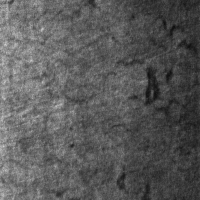

2 Exemplo de Superfície Fissurada


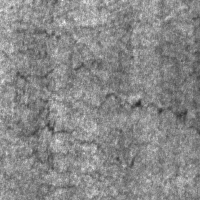

3 Exemplo de Superfície Fissurada


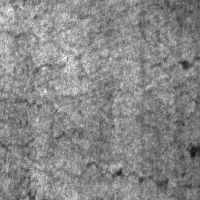

1 Exemplo de Superfície Esburacada


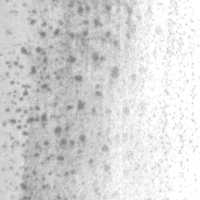

2 Exemplo de Superfície Esburacada


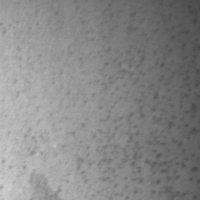

3 Exemplo de Superfície Esburacada


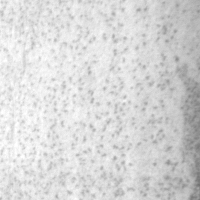

1 Exemplo de Arranhões


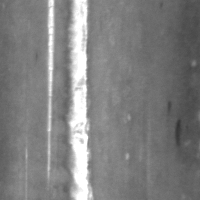

2 Exemplo de Arranhões


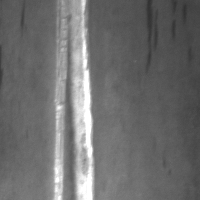

3 Exemplo de Arranhões


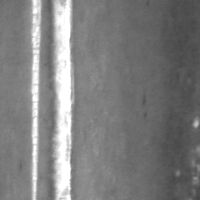

1 Exemplo de Inclusão


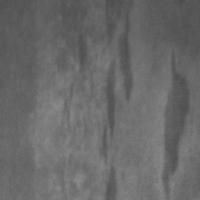

2 Exemplo de Inclusão


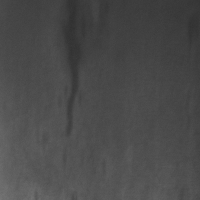

3 Exemplo de Inclusão


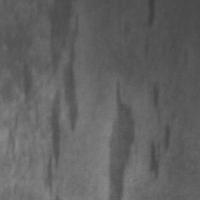

1 Exemplo de Manchas


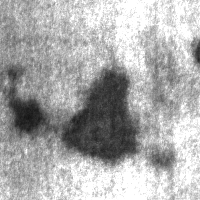

2 Exemplo de Manchas


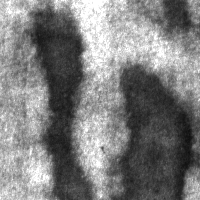

3 Exemplo de Manchas


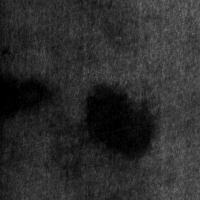

1 Exemplo de Escama de Laminação


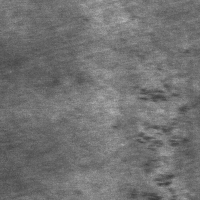

2 Exemplo de Escama de Laminação


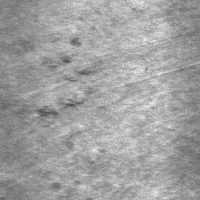

3 Exemplo de Escama de Laminação


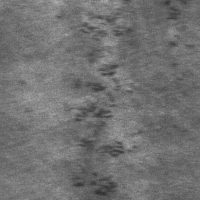

In [ ]:
from IPython.display import display

rs_count = 0
pa_count = 0
cr_count = 0
ps_count = 0
in_count = 0
sc_count = 0

for file in files_paths:
  if 'RS' in file and rs_count < 3:
    print(f'{rs_count+1} Exemplo de Escama de Laminação')
    img = Image.open(file)
    display(img)
    rs_count += 1

  elif 'Pa' in file and pa_count < 3:
    print(f'{pa_count+1} Exemplo de Manchas')
    img = Image.open(file)
    display(img)
    pa_count += 1

  elif 'Cr' in file and cr_count < 3:
    print(f'{cr_count+1} Exemplo de Superfície Fissurada')
    img = Image.open(file)
    display(img)
    cr_count += 1

  elif 'PS' in file and ps_count < 3:
    print(f'{ps_count+1} Exemplo de Superfície Esburacada')
    img = Image.open(file)
    display(img)
    ps_count += 1

  elif 'In' in file and in_count < 3:
    print(f'{in_count+1} Exemplo de Inclusão')
    img = Image.open(file)
    display(img)
    in_count += 1

  elif 'Sc' in file and sc_count < 3:
    print(f'{sc_count+1} Exemplo de Arranhões')
    img = Image.open(file)
    display(img)
    sc_count += 1

## 3. Pré-Processamento
Com base na exploração inicial, é necessário que os dados estejam em um formato adequado para que o modelo seja capaz de aprender o problema. Basicamente nós identificamos a representatividade da amostra ao manipular o volume, transformar, filtrar e descrever os dados.


In [ ]:
!pip install seaborn


In [ ]:
import seaborn as sns


**Normalização:** Normalizamos os valores dos pixels para o intervalo [0, 1] para melhor resposta da aplicação das funções de ativação durante o forward pass.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normaliza os valores dos pixels
])

In [ ]:
print("Tamanho de image_paths:", len(files_paths))
print("Tamanho de labels:", len(labels))

Tamanho de image_paths: 1800
Tamanho de labels: 1800


Classes balanceadas nos conjuntos de treino, validação e teste, para garantir que a acurácia não esteja com viés.

In [ ]:
files_paths = np.array(files_paths)
labels = np.array(labels)

train_files, test_files, train_labels, test_labels = train_test_split(
    files_paths, labels, test_size=0.2, random_state=42, stratify=labels)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.25, random_state=42, stratify = train_labels)

print("Tamanho do conjunto de treinamento:", len(train_files))
print("Tamanho do conjunto de validação:", len(val_files))
print("Tamanho do conjunto de teste:", len(test_files))

Tamanho do conjunto de treinamento: 1080
Tamanho do conjunto de validação: 360
Tamanho do conjunto de teste: 360


In [ ]:
print ("Treino")
print(np.unique(train_labels, return_counts=True))

print ("Validacao")
print(np.unique(val_labels, return_counts=True))

print ("Teste")
print(np.unique(test_labels, return_counts=True))

Treino
(array([0, 1, 2, 3, 4, 5]), array([180, 180, 180, 180, 180, 180]))
Validacao
(array([0, 1, 2, 3, 4, 5]), array([60, 60, 60, 60, 60, 60]))
Teste
(array([0, 1, 2, 3, 4, 5]), array([60, 60, 60, 60, 60, 60]))


Mesmo que as imagens estejam em escala de cinza, nós fazemos uma conversão para RGB a fim de que o modelo MLP Convolucional tenha 3 canais, o que evita erros de dimensionamento e permita o aprendizado correto de características.

In [ ]:
class MetalSurfaceDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        filepath = self.file_paths[idx]
        img = Image.open(filepath).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = MetalSurfaceDataset(train_files, train_labels, transform)
val_dataset = MetalSurfaceDataset(val_files, val_labels, transform)
test_dataset = MetalSurfaceDataset(test_files, test_labels, transform)

print('Set de treino: ', len(train_dataset))
print('Set de teste: ', len(test_dataset))

Set de treino:  1080
Set de teste:  360


## 3.1 Protocolo de Validação
Para treinar e avaliar de maneira estatisticamente confiável, nós iremos utilizar **K-Fold Cross-Validation**. Basicamente iremos dividir nosso conjunto de dados em K subconjuntos ou folds.

Realizaremos K rodadas em que cada subconjunto terá 1/K exemplos para realizar teste, enquanto o resto é para treino. Ou seja, teremos K-1 conjuntos de treinamento por K rodadas, enquanto 1 subconjunto será para teste.

O desempenho do modelo é medido em cada fold, e a média dos resultados das K rodadas é usado como estimativa de desempenho.

O método é mais robusto por reduzir viés na divisão das 6 classes, que mesmo balanceadas (300 amostras de cada tipo), poderiam ser mal divididas ao simplesmente usar Holdout Cross-Validation, pois este não usa todas as amostras do conjunto de dados para treino e teste.

Segundo a literatura, Peter Norvig e Stuart Russel em Artificial Intelligence: A Modern Approach 5th Edition, citam K=5 como estatisticamente confiável para o número de Folds.

In [ ]:
from sklearn.model_selection import KFold

# objeto KFold instanciado
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Extração de Padrões
Nessa etapa escolhemos a tarefa do modelo, que no caso é a classificação das imagens em rótulos de defeito.

Nosso modelo de Rede Neural Convolucional (CNN) é amplamente utilizado para tratamento de imagens, em que recebe um conjunto de vetores de características otimizados.

A **Spatial Invariance** explica que estruturas e objetos podem aparecer em lugares diferentes da imagem, isto é, se buscamos defeitos, eles podem aparecer em diferentes partes da imagem, o que dificulta o reconhecimento e, no caso de uma tarefa de classificação, rotular corretamente a amostra.

Para resolver isso, uma CNN traz um conceito chamado **From Low-Level to High-Level Features**, que consiste em combinar informações fechadas espacialmente (low-level features).

A estrutura de uma MLP Profunda Convolucional é basicamente:
- **Filter Maps:** É a camada em que aplicamos filtros em pedaços da imagem.
  - **Kernel (Filtro):** Conjunto de pesos;
  - **Convolution:** É o processo de pegar um patch (pedaço) da imagem e aplicar um Kernel (Filtro);
  - **Repetição:** Até que tenhamos uma quantidade de Filter Maps suficientemente adequada, em que se pode dizer que os Filter Maps aprendem as características de forma satisfatória.
- **Receptive Field:** É a região atualmente analisada rede quando nomeamos um pixel. Quanto maior o Receptive Field, maior o aprendizado;
- **Pooling Layer:** É a camada em que redimensionamos os maps e elencamos as principais características;
- **Flattening:** É o processo de vetorizar os Filter Maps em Arrays de características como atributos para a camada de entrada da rede.

## 4.1  Feature Extraction Layers
Sendo assim, a arquitetura do modelo é implementada em uma classe de 14 camadas, sendo 3 convolucionais:
- **1° Camada - Convolucional Bidimensional:** É a primeira camada, que utiliza 3 canais de cores RGB, 32 Filter Maps e um Kernel (filtro) de 3x3 pixels, adicionando ainda um padding de tamanho 1 para manter o tamanho da saída igual ao da entrada;
- **2° Camada - Batch Normalization:** Aplicamos a normalização nos lotes para acelerar o treinamento e minimizar instabilidades durante o processamento. Como temos 32 Mapas de Características na primeira camada, iremos normalizar todos eles;
- **3° Camada - Função de Ativação:** Utilizamos a função de ativação ReLu, que é uma das mais comumente usadas para introduzir a não linearidade (aprende relações mais complexos, isto é, polinomiais ou exponenciais);
- **4° Camada - Max Pooling:** Redução da dimensionalidade das imagens, tornando a rede invariante a pequenas translações. Usamos um Kernel 2x2 pixels para reduzir o tamanho da imagem pela metade, um stride 2 para mover o Kernel de 2 em 2 pixels. Em outras palavras, o que chamamos de **Translational Invariance** nos permite trabalhar com imagens que mesmo diante de pequenas mudanças, sempre nos levam à mesma saída.
- **5° Camada - Convolução:** Por fim aplicamos uma convolução bidimensional novamente, mas dessa vez na camada de Max Pooling. Como a camada anterior tem 32 mapas de características, iremos espera-las em 32 canais diferentes. Também produziremos 64 mapas de características e usaremos um Kernel de 3x3 na convolução.
- **6° Camada - Batch Normalization:** Aplicamos a normalização dos 64 lotes na 2° camada de convolução;
- **7° Camada - ReLu:** Aplicamos a não linearidade nos lotes normalizados.
- **8° Camada - Max Pooling:** Reduzimos a dimensionalidade dos lotes utilizando o Max Pooling. Diminuímos o tamanho da imagem pela metade ao utilizar um Kernel de 2x2 pixels, com um stride de 2 para mover o Kernel;
- **9° Camada - Convolução**: Aplicamos novamente uma convolução bidimensional, utilizando os 64 Mapas de Características da camada anterior em 64 canais, e para essa camada produziremos 128 mapas de características. Por fim, utilizamos um Kernel de 3x3 na convolução para extrair o máximo de informação relevante;
- **10° Camada - Batch Normalization:** Normalizamos os 128 lotes na 3° camada de convolução;
- **11° Camada - ReLu:** Aplicamos a não linearidade nos lotes normalizados da 3° camada de convolução;
- **12° Camada - Max Pooling:** Reduzimos a dimensionalidade dos lotes utilizando o Max Pooling da 3° camada de convolução. Diminuímos o tamanho da imagem pela metade ao utilizar um Kernel de 2x2 pixels, com um stride de 2 para mover o Kernel;

- **13° Camada - Adaptive Average Pooling:** Reduzimos a dimensionalidade da saída das 3 camadas convolucionais para um tamanho fixo de 1x1 pixels. Isso permite o uso de uma camada totalmente conectada (linear) com um número fixo de entradas, independente do tamanho da entrada original;

- **14° Camada - Linear (Fully-Connected):** Aplicamos uma transformação linear à saída da camada de pooling anterior para produzir as previsões finais. A entrada tem 128 características (a saída da camada de pooling anterior), e a saída tem um número variável de neurônios, dependendo do número de classes.

In [ ]:
class CNN(nn.Module):
  def __init__(self, classes=6):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.fc = nn.Linear(128, classes)

  def forward(self, x):
        # aplicamos as camadas convolucionais e de pooling, sendo

        # primeira camada
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))

        # segunda camada
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))

        # terceira camada
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))

        # criamos a fully-connected layer
        x = self.avgpool(x)

        # aplanamos a saida para um vetor
        x = torch.flatten(x, 1)

        # aplicamos a fully-connected layer SOBRE
        # a arquitetura que especificamos
        x = self.fc(x)
        return x

In [ ]:
# faco apenas a selecao de processador atraves do colab
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.7 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1-cp311-cp311-linux_x86_64.whl size=660393 sha256=efbe9f0566463574808f33f15774d9bf8709975ab381e0bff4bbc7084d134d2a
  Stored in directory: /root/.cache/pip/wheels/77/7e/6c/d2d1451ea6424cdc3d67b36c16fa7111eafdf2034bc3405666
Successfully built pycuda


In [ ]:
import psutil
import humanize
import platform
import os

def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

uname = platform.uname()
print(f"Sistema: {uname.system}")
print(f"Nome da máquina: {uname.node}")
print(f"Versão: {uname.version}")
print(f"Processador: {uname.machine}")
print("---------------------CPU Info---------------------")
print("Número de núcleos físicos:", psutil.cpu_count(logical=False))
print("Número total de núcleos:", psutil.cpu_count(logical=True))
cpufreq = psutil.cpu_freq()
print(f"Frequência máxima: {cpufreq.max:.2f}Mhz")
print(f"Frequência mínima: {cpufreq.min:.2f}Mhz")
print(f"Frequência atual: {cpufreq.current:.2f}Mhz")
print("Uso total da CPU por núcleo:")
for i, percentage in enumerate(psutil.cpu_percent(percpu=True, interval=1)):
    print(f"Núcleo {i}: {percentage}%")
print(f"Uso total da CPU: {psutil.cpu_percent()}%")
print("---------------------Memória Info---------------------")
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}")
print(f"Disponível: {get_size(svmem.available)}")
print(f"Usada: {get_size(svmem.used)}")
print(f"Porcentagem: {svmem.percent}%")
print("---------------------Informação de SWAP---------------------")
swap = psutil.swap_memory()
print(f"Total: {get_size(swap.total)}")
print(f"Disponível: {get_size(swap.free)}")
print(f"Usada: {get_size(swap.used)}")
print(f"Porcentagem: {swap.percent}%")
print("---------------------Informação de Disco---------------------")
print("Partições e Pontos de Montagem:")
partitions = psutil.disk_partitions()
for partition in partitions:
    print(f"  --- Dispositivo: {partition.device} ---")
    print(f"  Ponto de Montagem: {partition.mountpoint}")
    print(f"  Tipo de Sistema de Arquivos: {partition.fstype}")
    try:
        partition_usage = psutil.disk_usage(partition.mountpoint)
    except PermissionError:
        continue
    print(f"  Tamanho Total: {get_size(partition_usage.total)}")
    print(f"  Usado: {get_size(partition_usage.used)}")
    print(f"  Livre: {get_size(partition_usage.free)}")
    print(f"  Porcentagem: {partition_usage.percent}%")
print("---------------------Informação de Rede---------------------")
ifaces = psutil.net_if_addrs()
for interface_name, interface_addresses in ifaces.items():
    for address in interface_addresses:
        print(f"Interface: {interface_name}")
        if str(address.family) == 'AddressFamily.AF_INET':
            print(f"  Endereço IP: {address.address}")
            print(f"  Máscara de Rede: {address.netmask}")
            print(f"  Endereço de Broadcast: {address.broadcast}")
        elif str(address.family) == 'AddressFamily.AF_PACKET':
            print(f"  Endereço MAC: {address.address}")
            print(f"  Máscara de Rede: {address.netmask}")
            print(f"  Endereço de Broadcast: {address.broadcast}")
net_io = psutil.net_io_counters()
print(f"Bytes enviados: {get_size(net_io.bytes_sent)}")
print(f"Bytes recebidos: {get_size(net_io.bytes_recv)}")

Sistema: Linux
Nome da máquina: 9e0b0c407780
Versão: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Processador: x86_64
---------------------CPU Info---------------------
Número de núcleos físicos: 1
Número total de núcleos: 2
Frequência máxima: 0.00Mhz
Frequência mínima: 0.00Mhz
Frequência atual: 2000.22Mhz
Uso total da CPU por núcleo:
Núcleo 0: 28.3%
Núcleo 1: 16.2%
Uso total da CPU: 22.0%
---------------------Memória Info---------------------
Total: 12.67GB
Disponível: 11.06GB
Usada: 1.30GB
Porcentagem: 12.7%
---------------------Informação de SWAP---------------------
Total: 0.00B
Disponível: 0.00B
Usada: 0.00B
Porcentagem: 0.0%
---------------------Informação de Disco---------------------
Partições e Pontos de Montagem:
  --- Dispositivo: /dev/root ---
  Ponto de Montagem: /usr/sbin/docker-init
  Tipo de Sistema de Arquivos: ext2
  Tamanho Total: 1.93GB
  Usado: 1.13GB
  Livre: 819.42MB
  Porcentagem: 58.5%
  --- Dispositivo: /dev/sda1 ---
  Ponto de Montagem: /usr/lib64-nvid

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
import platform

def get_gpu_info():
    device_count = cuda.Device.count()
    if device_count == 0:
        print("Nenhuma GPU CUDA detectada.")
        return

    for i in range(device_count):
        gpu = cuda.Device(i)
        print(f"--- Informações da GPU {i} ---")
        print(f"Nome: {gpu.name()}")
        print(f"Memória Total: {gpu.total_memory() / (1024 ** 2):.2f} MB")

        # Informações de memória
        mem_info = cuda.mem_get_info()
        print(f"Memória Livre: {mem_info[0] / (1024 ** 2):.2f} MB")
        print(f"Memória Usada: {(gpu.total_memory() - mem_info[0]) / (1024 ** 2):.2f} MB")

        print("----------------------------")

# Informações do sistema
uname = platform.uname()
print(f"Sistema: {uname.system}")
print(f"Nome da máquina: {uname.node}")
print(f"Versão: {uname.version}")
print(f"Processador: {uname.machine}")
print("---------------------GPU Info---------------------")
get_gpu_info()

Sistema: Linux
Nome da máquina: 9e0b0c407780
Versão: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Processador: x86_64
---------------------GPU Info---------------------
--- Informações da GPU 0 ---
Nome: Tesla T4
Memória Total: 15095.06 MB
Memória Livre: 14992.12 MB
Memória Usada: 102.94 MB
----------------------------


**Treinamento:** Instanciamos uma funcao para treinar a CNN, iterando sobre todo o conjunto de dados por N épocas (rodadas de avanço dos dados da camada de entrada para a de saída). Os parâmetros necessários são:
- Data Loader: Fornece os dados em lotes;
- Criterion: É a função de perda;
- Optimizer: O otimizador, como ADAM;
- Epochs: Iteração sobre os subsets. de dados.

**Early Stopping:** A fim de prevenir memorização (sobreajuste) das amostras, vamos observar a perda de validação. Se ela não melhorar (diminuir) durante um número de Patience o treinamento será interrompido, o que indica incidência de overfitting.

**Avaliação:** Para tarefas de classificação, geralmente nós temos duas funções de avaliação possíveis: Acurácia e Cross Entropy Loss. A primeira mede (Predições corretas)/(Total de exemplos), geralmente usada no teste para avaliar o desempenho, enquanto a segunda mede a diferença entre a distribuição de probabilidade prevista e a real, penalizando o modelo ao fazer previsões incorretas. Como qualquer perda, a ideia é que ela seja minimizada, o que induz o modelo a se esforçar para aprender os dados (durante o backpropagation).

In [ ]:
def evaluate_hypotesis(model, data_loader, criterion):
  model.eval()
  correct = 0
  total = 0
  total_loss = 0.0

  with torch.no_grad():
    # itero sobre o par (X,Y) do data loader
    for imgs, labels in data_loader:
      # mapeio os dados para o processador do modelo
      imgs = imgs.to(device)
      labels = labels.to(device)

      # pego a ultima saida do modelo
      outputs = model(imgs)

      # cross entropy loss aplicada no set
      loss = criterion(outputs, labels)
      total_loss += loss.item()

      # obtenho a classe predita para os
      # valores mais altos em cada Batch
      _, predicted = torch.max(outputs.data, 1)

      # um contador de amostras
      total += labels.size(0)

      # conto os rotulos corretos para cada amostra
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  average_loss = total_loss / len(data_loader)

  return accuracy, average_loss

In [ ]:
def train_hypotesis(model, train_loader, val_loader, criterion, optimizer, epochs, patience=3):
    model.train()
    train_losses = []
    best_val_loss = float('inf')
    all_val_accuracies = []
    all_val_losses = []

    # Contador para o early stopping
    epochs_without_improvement = 0

    for epoch in range(epochs):
        losses = 0.0
        for i, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Forward Pass
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # Backward Pass e Otimização
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses += loss.item()

        epoch_loss = losses / len(train_loader)
        train_losses.append(epoch_loss)

        """
        Justificativa: A avaliação da perda de validação deve ser feita após cada
        epoch de treinamento, pois o conjunto de validacao e o que
        representa o desempenho do modelo em dados que ele nunca viu antes
        """
        val_accuracy, val_loss = evaluate_hypotesis(model, val_loader, criterion)

        print(f"Acurácia de validação: {val_accuracy:.2f}%")
        all_val_accuracies.append(val_accuracy)
        all_val_losses.append(val_loss)

        # Verificação de early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Se não houver melhoria por 'patience' epochs, para o treinamento
        if epochs_without_improvement >= patience:
            print(f"Early stopping: Validação não melhorou por {patience} épocas.")
            break

    return train_losses, all_val_accuracies, all_val_losses

In [ ]:
from sklearn.metrics import confusion_matrix
import imageio

def test_hypotesis(model, test_loader, classes=6, class_names=None, filename='predictions.gif'):
    model.eval()
    y_true = []
    y_pred = []
    correct = 0
    total = 0

    images = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if class_names:
                for i in range(len(imgs)):
                    img = imgs[i].cpu().numpy()[0]
                    true_label = class_names[labels[i].item()]
                    pred_label = class_names[predicted[i].item()]

                    fig, ax = plt.subplots()
                    ax.imshow(img, cmap='gray')
                    ax.set_title(f'Real: {true_label} | Previsto: {pred_label}')
                    ax.axis('off')
                    fig.canvas.draw()
                    image = np.array(fig.canvas.renderer.buffer_rgba())
                    plt.close(fig)
                    images.append(image)

    if images:
        imageio.mimsave(filename, images, duration=1.5)
        print(f'GIF salvo como {filename}')

    accuracy = 100 * correct / total
    cm = confusion_matrix(y_true, y_pred)

    mean_accuracy = np.mean(accuracy)
    std_accuracy = np.std(accuracy)

    print(f"Acurácia: {mean_accuracy:.2f}%")
    print(f"Desvio padrão da acurácia: {std_accuracy:.2f}%")

    return cm, mean_accuracy, std_accuracy

def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
    plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
    plt.title('Confusion Matrix')
    plt.show()

## 4.1 Experimento
Nossa ideia será treinar 5 hipoteses e selecionar a melhor delas. Ou seja, faremos diferentes configurações de hiperparâmetros e avaliaremos a que melhor se ajusta aos dados sem cometer Overfitting ou Underfitting e claro, de maneira subjetiva.

In [ ]:
# hyperparameter_configs = [
#     {"name": "Config_1", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 32, "n_epochs":10},
#     {"name": "Config_2", "lr": 1e-4, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":10},
#     {"name": "Config_3", "lr": 1e-3, "weight_decay": 1e-4, "batch_size": 32, "n_epochs":10},
#     {"name": "Config_4", "lr": 1e-4, "weight_decay": 1e-4, "batch_size": 64, "n_epochs":10},
#     {"name": "Config_5", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":10},
#     {"name": "Config_6", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 32, "n_epochs":15},
#     {"name": "Config_7", "lr": 1e-4, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":15},
#     {"name": "Config_8", "lr": 1e-3, "weight_decay": 1e-4, "batch_size": 32, "n_epochs":15},
#     {"name": "Config_9", "lr": 1e-4, "weight_decay": 1e-4, "batch_size": 64, "n_epochs":15},
#     {"name": "Config_10", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":15},
#     {"name": "Config_11", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 32, "n_epochs":20},
#     {"name": "Config_12", "lr": 1e-4, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":20},
#     {"name": "Config_13", "lr": 1e-3, "weight_decay": 1e-4, "batch_size": 32, "n_epochs":20},
#     {"name": "Config_14", "lr": 1e-4, "weight_decay": 1e-4, "batch_size": 64, "n_epochs":20},
#     {"name": "Config_15", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":20},
#     {"name": "Config_16", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 32, "n_epochs":25},
#     {"name": "Config_17", "lr": 1e-4, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":25},
#     {"name": "Config_18", "lr": 1e-3, "weight_decay": 1e-4, "batch_size": 32, "n_epochs":25},
#     {"name": "Config_19", "lr": 1e-4, "weight_decay": 1e-4, "batch_size": 64, "n_epochs":25},
#     {"name": "Config_20", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":25},
#     {"name": "Config_21", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 32, "n_epochs":200},
#     {"name": "Config_22", "lr": 1e-4, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":200},
#     {"name": "Config_23", "lr": 1e-3, "weight_decay": 1e-4, "batch_size": 32, "n_epochs":200},
#     {"name": "Config_24", "lr": 1e-4, "weight_decay": 1e-4, "batch_size": 64, "n_epochs":200},
#     {"name": "Config_25", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":200},
#     {"name": "Config_26", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 32, "n_epochs":1000},
#     {"name": "Config_27", "lr": 1e-4, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":1000},
#     {"name": "Config_28", "lr": 1e-3, "weight_decay": 1e-4, "batch_size": 32, "n_epochs":1000},
#     {"name": "Config_29", "lr": 1e-4, "weight_decay": 1e-4, "batch_size": 64, "n_epochs":1000},
#     {"name": "Config_30", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":1000},
# ]

In [ ]:
hyperparameter_configs = [
    {"name": "Config_1", "lr": 1e-3, "weight_decay": 1e-5, "batch_size": 32, "n_epochs":250},
    {"name": "Config_2", "lr": 1e-4, "weight_decay": 1e-5, "batch_size": 64, "n_epochs":250},
    {"name": "Config_3", "lr": 1e-3, "weight_decay": 1e-4, "batch_size": 32, "n_epochs":250},
    {"name": "Config_4", "lr": 1e-4, "weight_decay": 1e-4, "batch_size": 64, "n_epochs":250},
    {"name": "Config_5", "lr": 1e-3, "weight_decay": 1e-3, "batch_size": 32, "n_epochs":250},
]

De forma mais ou menos arbitrária, mas levando em consideração que um valor baixo de Epoch pode levar a Underfitting e um valor alto pode levar a Overfitting, consideramos mais de 250 Epochs por configuração no treinamento contando com a penalização do modelo via **Early Stopping**, com 10 de Patience.

In [ ]:
gc.collect()

13

[1/5] Testando a configuração Config_1
Fold 1
Acurácia de validação: 35.19%
Acurácia de validação: 72.69%
Acurácia de validação: 82.41%
Acurácia de validação: 82.87%
Acurácia de validação: 86.11%
Acurácia de validação: 87.96%
Acurácia de validação: 82.87%
Acurácia de validação: 89.35%
Acurácia de validação: 88.89%
Acurácia de validação: 87.96%
Acurácia de validação: 86.11%
Acurácia de validação: 86.57%
Acurácia de validação: 89.81%
Acurácia de validação: 91.20%
Acurácia de validação: 87.96%
Acurácia de validação: 92.59%
Acurácia de validação: 89.35%
Acurácia de validação: 93.52%
Acurácia de validação: 92.13%
Acurácia de validação: 92.59%
Acurácia de validação: 92.59%
Acurácia de validação: 93.06%
Acurácia de validação: 90.28%
Acurácia de validação: 90.28%
Acurácia de validação: 93.52%
Acurácia de validação: 93.52%
Acurácia de validação: 92.13%
Acurácia de validação: 95.37%
Acurácia de validação: 94.44%
Acurácia de validação: 93.98%
Acurácia de validação: 93.52%
Acurácia de validação: 9

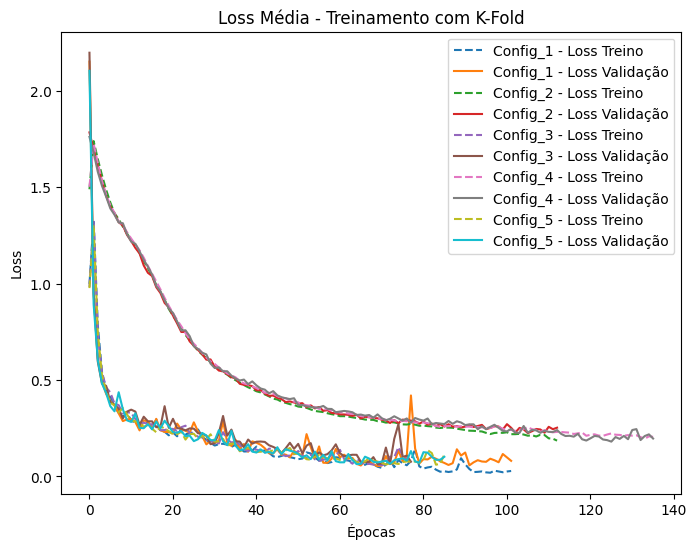

In [ ]:
from torch.utils.data import SubsetRandomSampler
import numpy as np

all_results = []

for config_idx, config in enumerate(hyperparameter_configs):
    print(f"[{config_idx+1}/{len(hyperparameter_configs)}] Testando a configuração {config['name']}")

    all_val_accuracies = []
    all_train_losses = []  # Lista para armazenar as perdas por época
    all_val_losses = []  # Lista para armazenar as perdas de validação por época

    # K-Fold Cross Validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        gc.collect()
        print(f"Fold {fold + 1}")

        # Crio um seletor aleatório de amostras para cada subset tanto para treino quanto para teste
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        # Separo os dados em lotes do tamanho do batch size
        train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=config["batch_size"], sampler=val_sampler)

        # Mapeio o modelo para o processador disponível (GPU ou CPU)
        model = CNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

        # Treinamento e validacao do fold para a configuração atual
        train_losses, fold_val_accuracy, fold_val_losses = train_hypotesis(model, train_loader, val_loader, criterion, optimizer, config["n_epochs"], patience=10)

        # Armazeno as métricas da validação e do treino por época
        all_val_accuracies.append(fold_val_accuracy)
        all_val_losses.append(fold_val_losses)
        all_train_losses.append(train_losses)

    # Identifico o maior número de épocas entre todos os folds
    max_epochs = max(len(fold_losses) for fold_losses in all_train_losses)

    # Preencho com NaN para garantir que todos os folds tenham o mesmo número de épocas
    padded_train_losses = [fold_losses + [np.nan] * (max_epochs - len(fold_losses)) for fold_losses in all_train_losses]
    padded_val_losses = [fold_losses + [np.nan] * (max_epochs - len(fold_losses)) for fold_losses in all_val_losses]

    mean_train_loss = np.nanmean(padded_train_losses, axis=0)  # Média das perdas de treinamento por época
    mean_val_loss = np.nanmean(padded_val_losses, axis=0)  # Média das perdas de validação por época

    # Calculo a média e o desvio padrão da acurácia de validação
    mean_val_accuracy = np.mean([np.mean(fold_accuracies) for fold_accuracies in all_val_accuracies])
    std_val_accuracy = np.std([np.mean(fold_accuracies) for fold_accuracies in all_val_accuracies])

    # Calculo a média e o desvio padrão das perdas de validação
    std_val_loss = np.std(mean_val_loss)  # Desvio padrão da perda média de validação por época
    std_train_loss = np.std(mean_train_loss)  # Desvio padrão da perda média de treinamento por época

    print(f"Acurácia média: {mean_val_accuracy:.2f}%")
    print(f"Desvio padrão da acurácia: {std_val_accuracy:.2f}%")

    # Salvo os resultados da configuração atual
    config['mean_accuracy'] = mean_val_accuracy
    config['std_accuracy'] = std_val_accuracy
    config['train_losses'] = mean_train_loss
    config['val_losses'] = mean_val_loss
    config['model'] = model

    all_results.append(config)

# Gráfico das Losses ao longo das epochs por configuracao
plt.figure(figsize=(8,6))
for result in all_results:
    plt.plot(result['train_losses'], label=f"{result['name']} - Loss Treino", linestyle="dashed")
    plt.plot(result['val_losses'], label=f"{result['name']} - Loss Validação")

plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Média - Treinamento com K-Fold")
plt.show()

In [ ]:
best_accuracy = 0

for config in all_results:
    if config['mean_accuracy'] > best_accuracy:
        best_accuracy = config['mean_accuracy']
        best_config = config

# salvo o modelo pra nao ter que compilar de novo
if best_config:
    best_model = best_config['model']
    model_name = best_config['name']
    torch.save(best_model.state_dict(), f'melhor_modelo_{model_name}.pth')
    print(f"Melhor modelo salvo como melhor_modelo_{model_name}.pth com acurácia média de {best_accuracy:.2f}%")
else:
    print("Nenhum modelo treinado encontrado.")

Melhor modelo salvo como melhor_modelo_Config_1.pth com acurácia média de 92.14%


# 5. Pós-Processamento
Nessa etapa é feita a análise dos padrões descobertos na fase de extração. Numa tentativa de avaliar se o modelo possui novos conhecimentos e capacidade de resolução da função objetivo, nós o usaremos para tomada de decisão, se não, repetimos a extração de padrões ou todo o processo a partir do pré-processamento.


Resultados:
Modelo: Config_1
Modelo: Config_5
Modelo: Config_3
Modelo: Config_4
Modelo: Config_2
GIF salvo como predictions.gif
Acurácia: 95.83%
Desvio padrão da acurácia: 0.00%


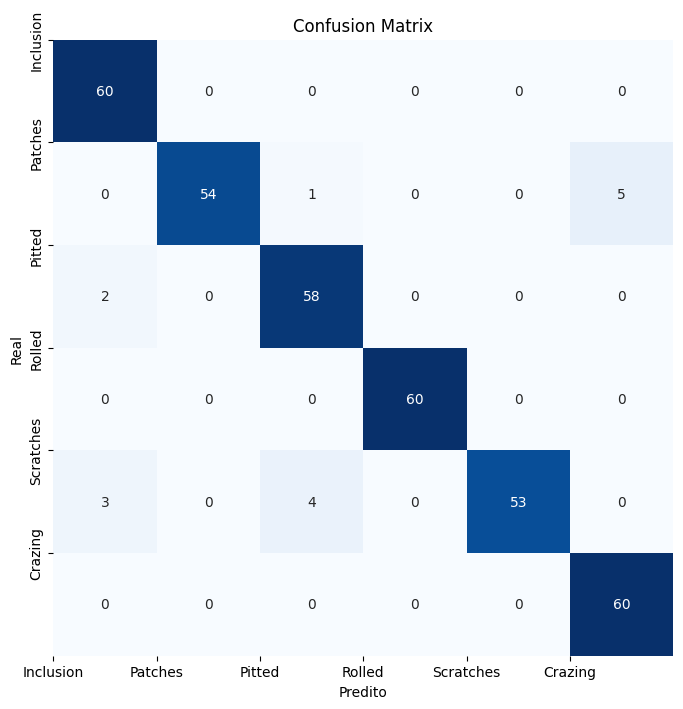

In [ ]:
best_results = sorted(all_results, key=lambda x: x['mean_accuracy'], reverse=True)

print("\nResultados:")
for i in range(len(all_results)):
    print(f"Modelo: {best_results[i]['name']}")

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

cm, mean_accuracy, std_accuracy = test_hypotesis(best_results[0]['model'], test_loader, class_names=list(label_map.keys()))

plot_confusion_matrix(cm, list(label_map.keys()))

## 5.1 Desempenho Geral

- Acurácia Média na Validação: 92%
- Acurácia no Teste: 95%
- Desvio Padrão da Acurácia no Teste: 0%
- Melhor configuração: Configuração 1 (maior acurácia), apresentando menor perda em comparação às demais. O gráfico de perda ao longo das épocas mostrou que a Configuração 1 teve a menor perda média, mas com algumas oscilações nas últimas épocas, o que pode indicar uma leve instabilidade, sujeito a melhorias numa implementação futura.

## 5.2 Matriz de Confusão

A seguir, apresentamos os resultados detalhados da classificação para cada categoria:

✅ Inclusion: 60/60 acertos (100% de precisão)

✅ Rolled: 60/60 acertos (100% de precisão)

✅ Crazing: 60/60 acertos (100% de precisão)

⚠️ Patches:
 - 54 amostras corretamente classificadas
 - 1 amostra classificada como Pitted
 - 5 amostras classificadas como Crazing

⚠️ Pitted:
- 58 amostras corretamente classificadas
- 2 amostras classificadas como Inclusion

⚠️ Scratches:
- 53 amostras corretamente classificadas
- 4 amostras classificadas como Pitted
- 3 amostras classificadas como Inclusion

### 5.3 Observações

- As classes Inclusion, Rolled e Crazing tiveram 100% de acerto.
- A classe Patches apresentou maior confusão com Crazing, o que pode indicar semelhança visual entre essas classes.
- O modelo conseguiu generalizar bem para o conjunto de teste, com 0% de desvio padrão na acurácia, o que sugere estabilidade nos resultados.
- O balanceamento de classes realizado antes do treinamento ajudou a evitar viés no modelo, garantindo um desempenho uniforme entre as categorias.
- Classes que performaram uma dificuldade maior na classificação podem ser investigadas no futuro para possíveis melhorias.